In [ ]:
import warnings
warnings.filterwarnings("ignore", module=r"matplotlib\..*")

# Analiza pitkosti vode
Klasifikacija vode na osnovu hemijskih parametara - da li je voda pitka ili ne.

In [ ]:
import pandas as pd
import numpy as np

columns = ['pH', 'Hardness', 'Solids','Chloramines','Sulfate','Conductivity','Organic_carbon','Trihalomethanes','Turbidity',
           'Potability']
target_column = 'Potability'

features = columns.copy()
features.remove(target_column)

## Ucitavanje i pregled podataka

In [ ]:
import os

relpath = '..\\data\\water_potability.csv'
abspath = os.path.abspath(relpath)

df = pd.read_csv(abspath, header=0, names=columns)

## Baseline Model (pre bilo kakve obrade podataka)
Treniramo jednostavne modele na sirovim podacima (sa dropovanjem redova koji imaju null vrednosti) da bismo imali referentnu tačku za poređenje sa modelima treniranim na obrađenim podacima.

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Baseline: dropujemo sve redove sa null vrednostima
df_baseline = df.dropna()
print(f"Baseline dataset: {len(df_baseline)} redova (originalno {len(df)})")

X_baseline = df_baseline.drop(columns=[target_column])
y_baseline = df_baseline[target_column]

# Baseline modeli
baseline_models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'NaiveBayes': GaussianNB()
}

# K-Fold Cross-Validation za baseline
kf_baseline = KFold(n_splits=5, shuffle=True, random_state=42)

print("\n=== BASELINE REZULTATI (sirovi podaci, bez obrade) ===")
print("Cross-validation sa 5 foldova:\n")
baseline_results_cv = {}
for name, model in baseline_models.items():
    scores = cross_val_score(model, X_baseline, y_baseline, cv=kf_baseline)
    baseline_results_cv[name] = {
        'mean': scores.mean(),
        'std': scores.std()
    }
    print(f"{name}: {scores.mean():.4f} (+/- {scores.std():.4f})")

best_baseline_name = max(baseline_results_cv, key=lambda x: baseline_results_cv[x]['mean'])
best_baseline_acc = baseline_results_cv[best_baseline_name]['mean']
print(f"\nNajbolji baseline model: {best_baseline_name} ({best_baseline_acc:.4f})")

Baseline dataset: 2011 redova (originalno 3276)

=== BASELINE REZULTATI (sirovi podaci, bez obrade) ===
Cross-validation sa 5 foldova:



c:\Users\anast\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\anast\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

LogisticRegression: 0.5987 (+/- 0.0288)
DecisionTree: 0.6141 (+/- 0.0300)
RandomForest: 0.6693 (+/- 0.0297)
KNN: 0.5455 (+/- 0.0157)
NaiveBayes: 0.6206 (+/- 0.0247)

Najbolji baseline model: RandomForest (0.6693)


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns



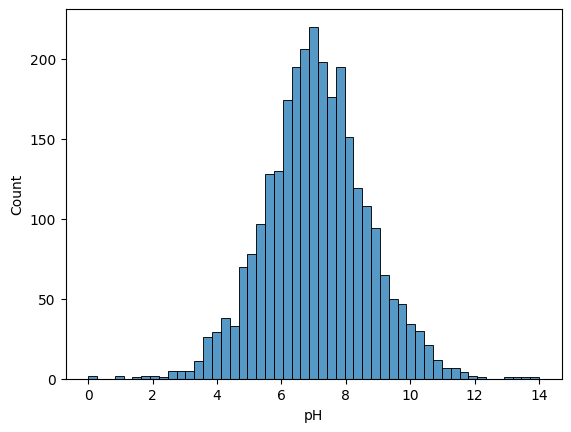

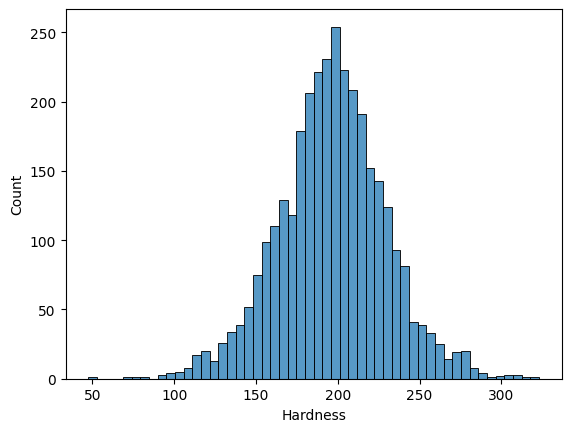

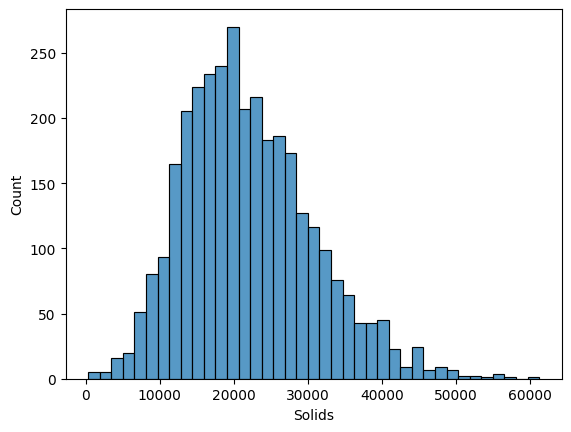

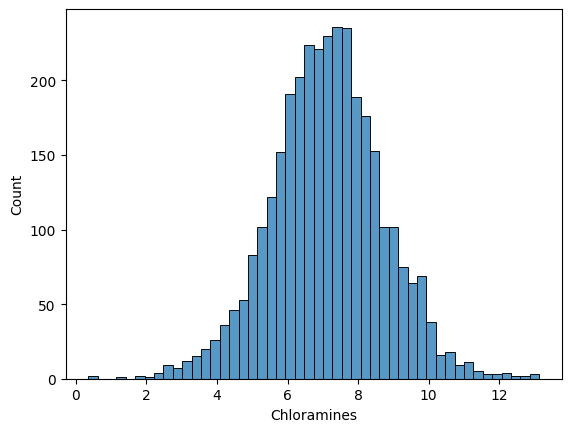

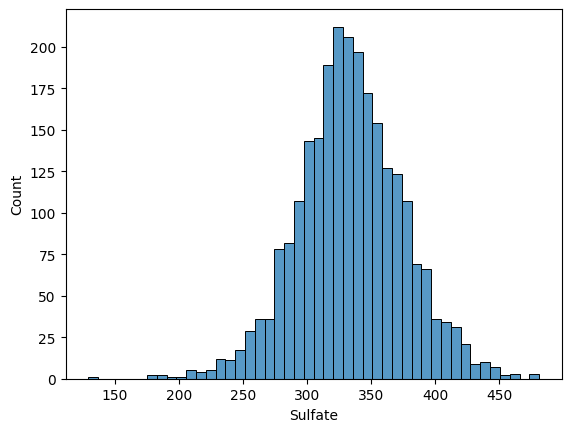

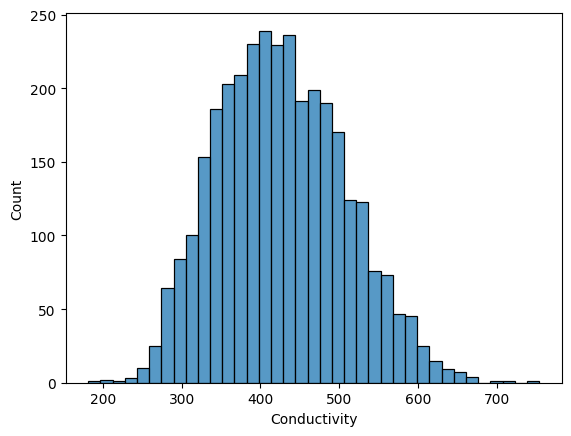

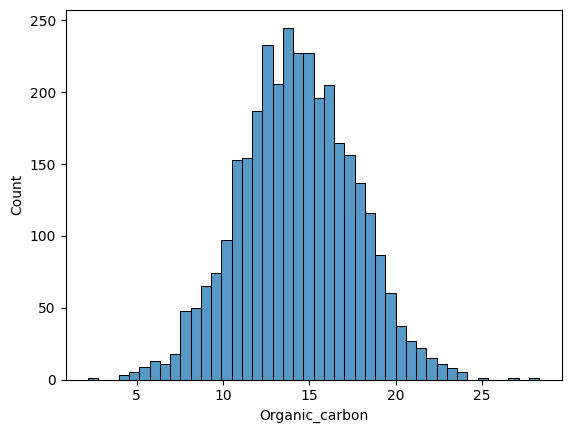

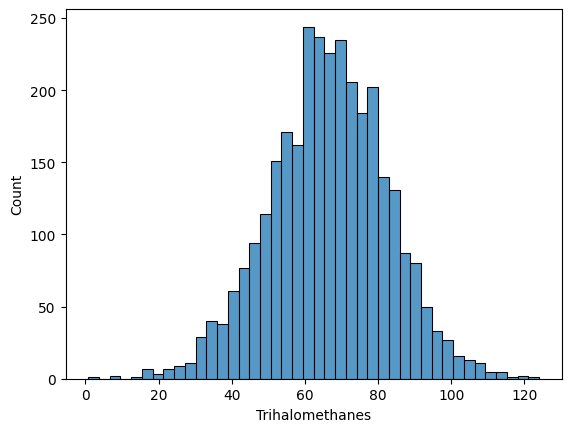

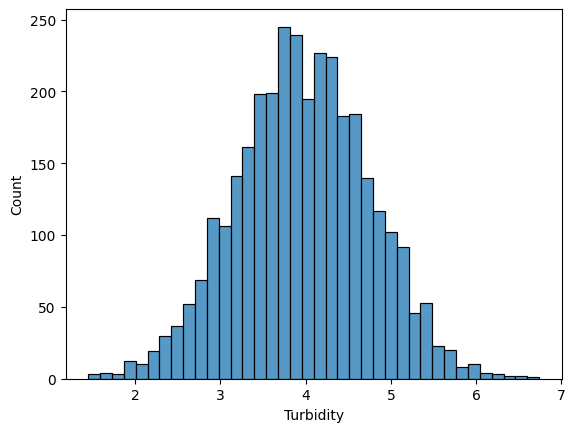

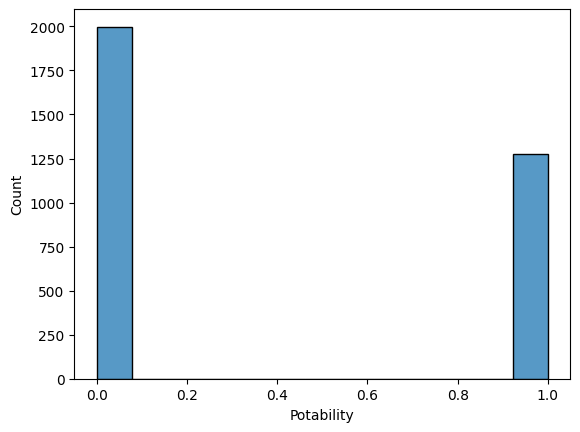

In [ ]:
features_tovisualize = features.copy()
for col in features_tovisualize + [target_column]:
    plt.figure()
    sns.histplot(data=df, x=col)
    

## Vizualizacija distribucije osobina

In [ ]:

duplicate_rows = df[df.duplicated()]
print("Duplicate Rows:")
print(duplicate_rows)

Duplicate Rows:
Empty DataFrame
Columns: [pH, Hardness, Solids, Chloramines, Sulfate, Conductivity, Organic_carbon, Trihalomethanes, Turbidity, Potability]
Index: []


## Analiza i obrada nedostajucih vrednosti

In [ ]:
numerical_features = df.select_dtypes(include='number').columns.tolist()
print(f'There are {len(numerical_features)} numerical features:')
print(numerical_features, '\n')

categorical_features = df.select_dtypes(exclude='number').columns.tolist()
print(f'There are {len(categorical_features)} categorical features:', '\n')
print(categorical_features)

There are 10 numerical features:
['pH', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'] 

There are 0 categorical features: 

[]


<Axes: >

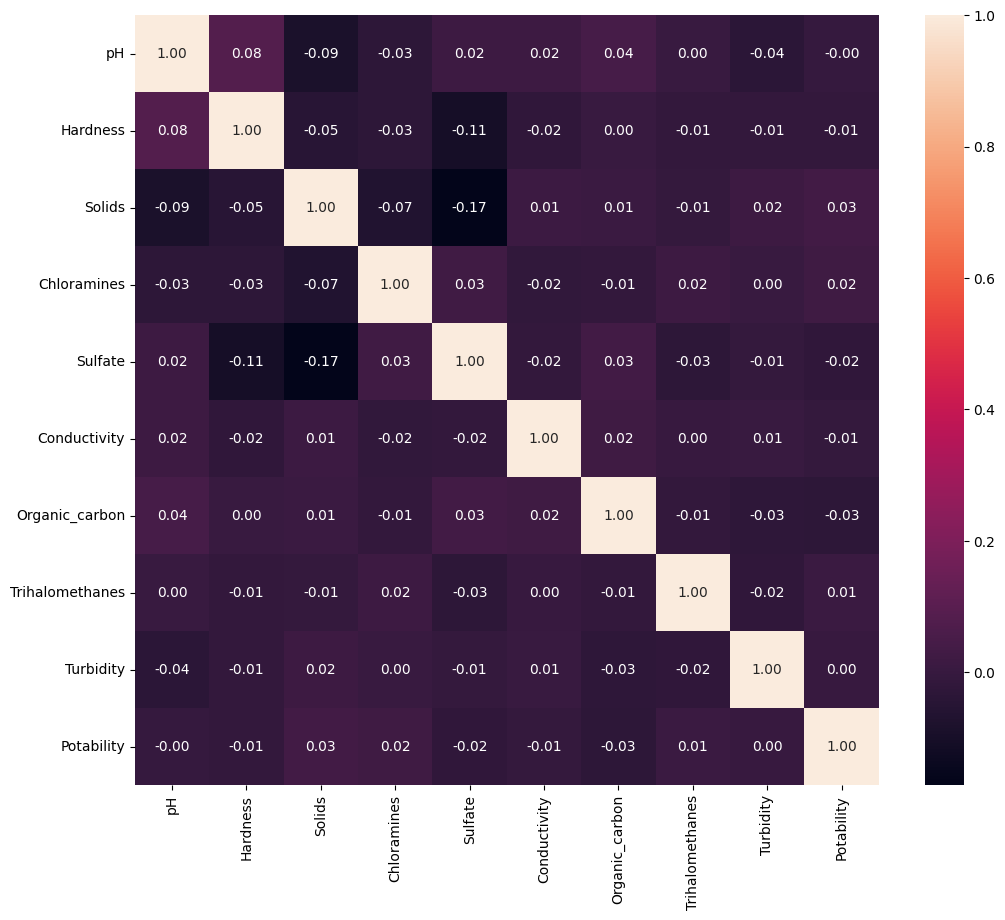

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f')

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pH               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [ ]:
df.isnull().sum()


pH                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [ ]:
df.describe()


,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [ ]:
df[df['Trihalomethanes'].isnull()]

,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
62,NaN,229.485694,35729.692709,8.810843,384.943779,296.397547,16.927092,NaN,3.855602,0
81,5.519126,168.728583,12531.601921,7.730723,NaN,443.570372,18.099078,NaN,3.758996,0
110,9.286155,222.661551,12311.268366,7.289866,332.239359,353.740100,14.171763,NaN,5.239982,0
118,7.397413,122.541040,8855.114121,6.888689,241.607532,489.851600,13.365906,NaN,3.149158,0
119,7.812804,196.583886,42550.841816,7.334648,NaN,442.545775,14.666917,NaN,6.204846,0
...,...,...,...,...,...,...,...,...,...,...
3174,6.698154,198.286268,34675.862845,6.263602,360.232834,430.935009,12.176678,NaN,3.758180,1
3185,6.110022,234.800957,16663.539074,5.984536,348.055211,437.892115,10.059523,NaN,2.817780,1
3219,6.417716,209.702425,31974.481631,7.263425,321.382124,289.450118,11.369071,NaN,4.210327,1
3259,9.271355,181.259617,16540.979048,7.022499,309.238865,487.692788,13.228441,NaN,4.333953,1


In [ ]:

columns_with_nulls = df.columns[df.isnull().any()]
columns_with_nulls

Index(['pH', 'Sulfate', 'Trihalomethanes'], dtype='object')

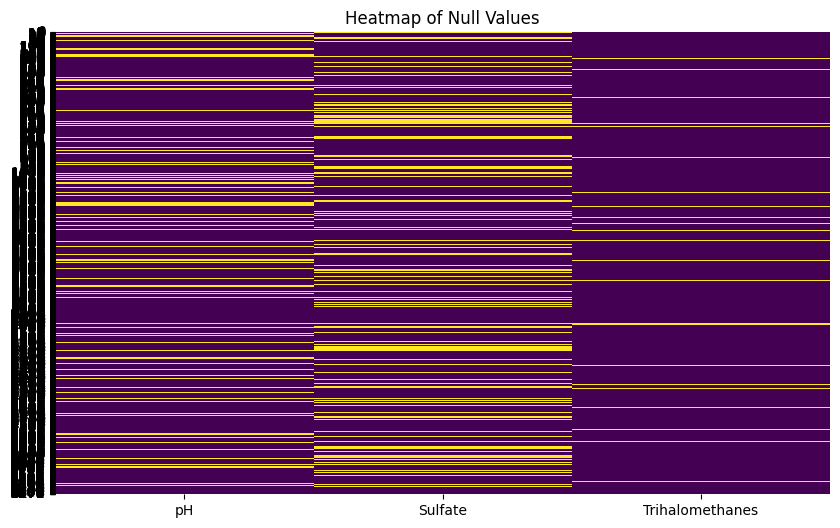

In [ ]:
plt.figure(figsize=(10, 6))

sns.heatmap(df[columns_with_nulls].isnull(), cbar=False, cmap='viridis', yticklabels=True)
plt.title('Heatmap of Null Values')
plt.show()

In [ ]:
rows_with_multiple_nulls = df[df.isnull().sum(axis=1) == 3]

print("Rows with more than one null value:")
rows_with_multiple_nulls.describe()

Rows with more than one null value:


,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,0.0,9.000000,9.000000,9.000000,0.0,9.000000,9.000000,0.0,9.000000,9.000000
mean,NaN,197.615548,22256.806396,6.832987,NaN,448.285723,13.164470,NaN,3.894027,0.111111
std,NaN,28.865246,11891.655823,1.436351,NaN,95.851968,3.088826,NaN,0.624907,0.333333
min,NaN,143.300200,11954.700730,4.933662,NaN,293.477998,8.816487,NaN,3.017985,0.000000
25%,NaN,184.993731,16162.262307,6.087949,NaN,391.238714,11.318807,NaN,3.451740,0.000000
50%,NaN,202.079864,17777.100086,6.657053,NaN,448.846036,12.934160,NaN,3.832479,0.000000
75%,NaN,221.620058,20944.620814,7.627524,NaN,538.621803,13.744749,NaN,4.439215,0.000000
max,NaN,229.771350,44982.734155,8.898024,NaN,566.339294,19.585497,NaN,4.863378,1.000000


In [ ]:
df = df.drop(rows_with_multiple_nulls.index)

In [ ]:
df['pH']=df['pH'].fillna(df.groupby(['Potability'])['pH'].transform('mean'))
df['Sulfate']=df['Sulfate'].fillna(df.groupby(['Potability'])['Sulfate'].transform('mean'))
df['Trihalomethanes']=df['Trihalomethanes'].fillna(df.groupby(['Potability'])['Trihalomethanes'].transform('mean'))

In [ ]:

from sklearn.impute import KNNImputer

In [ ]:
imputer = KNNImputer(n_neighbors=2)
df_filled = imputer.fit_transform(df)

In [ ]:
df[:]= imputer.fit_transform(df_filled)

In [ ]:
df.isnull().sum()

pH                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [ ]:
df[df['Potability']==0].describe()

,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.0
mean,7.085378,196.702451,21772.552012,7.092913,334.564290,426.671628,14.372386,66.303555,3.965866,0.0
std,1.548594,31.089068,8527.779592,1.501323,32.006042,79.982881,3.336573,15.674049,0.780915,0.0
min,0.000000,98.452931,320.942611,1.683993,203.444521,181.483754,4.371899,0.738000,1.450000,0.0
25%,6.217350,177.756096,15663.057382,6.156857,319.266920,368.498530,12.118536,56.404562,3.444062,0.0
50%,7.085378,197.090572,20827.950711,7.090334,334.564290,422.229331,14.310837,66.303555,3.949117,0.0
75%,7.945026,216.106273,27006.249009,8.066462,348.396008,480.580767,16.660188,76.599159,4.496106,0.0
max,14.000000,304.235912,61227.196008,12.653362,460.107069,753.342620,28.300000,120.030077,6.739000,0.0


In [ ]:
df[df['Potability']==1].describe()

,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.0
mean,7.073783,195.841857,22388.784145,7.170074,332.566990,425.322500,14.156645,66.539684,3.968733,1.0
std,1.344479,35.530558,9102.961906,1.703452,41.881787,82.051309,3.261649,15.978198,0.781014,0.0
min,0.227499,47.432000,728.750830,0.352000,129.000000,201.619737,2.200000,8.175876,1.492207,1.0
25%,6.351287,174.480427,15668.273618,6.093750,312.982727,360.932804,12.032377,56.910254,3.430167,1.0
50%,7.073783,196.649823,21208.618285,7.217409,332.566990,420.594592,14.162010,66.539684,3.958609,1.0
75%,7.780869,218.062384,27977.673208,8.199318,354.821194,484.104784,16.352858,77.079780,4.510578,1.0
max,13.175402,323.124000,56488.672413,13.127000,481.030642,695.369528,23.604298,124.000000,6.494249,1.0


<Axes: >

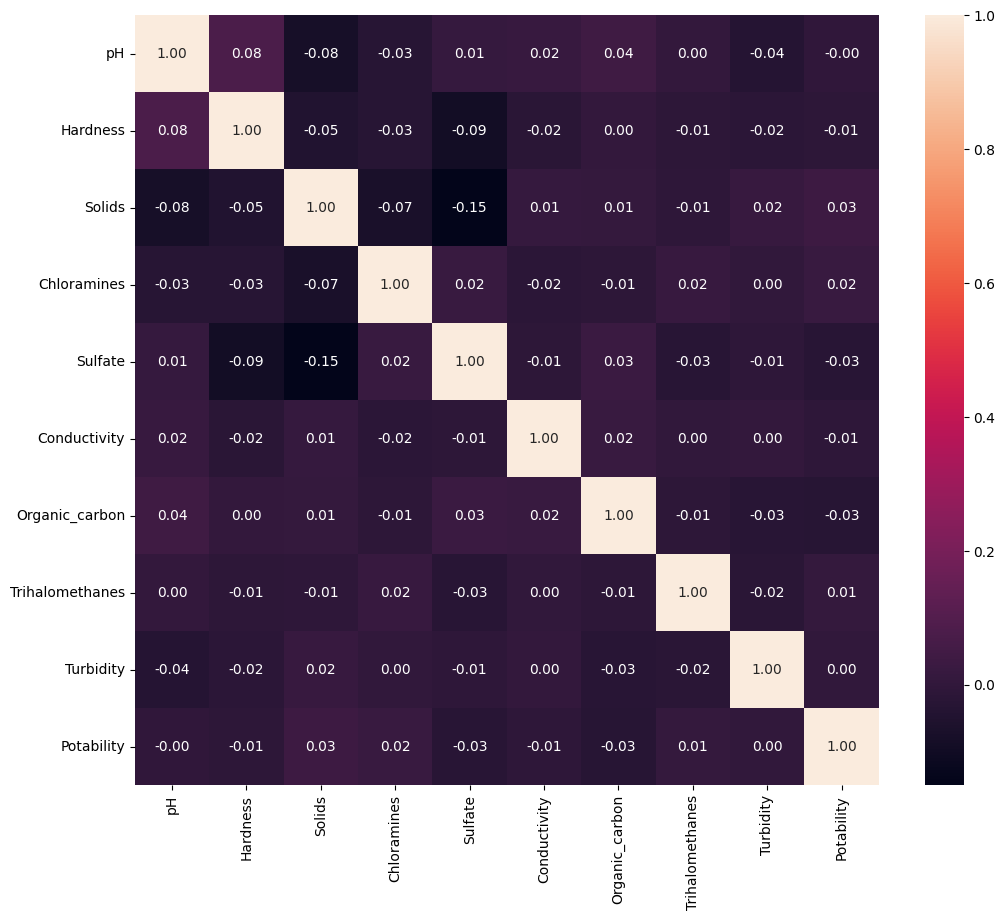

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f')

In [ ]:
numerical_features = df.select_dtypes(include='number').columns.tolist()
print(f'There are {len(numerical_features)} numerical features:')
print(numerical_features, '\n')

categorical_features = df.select_dtypes(exclude='number').columns.tolist()
print(f'There are {len(categorical_features)} categorical features:', '\n')
print(categorical_features)

There are 10 numerical features:
['pH', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'] 

There are 0 categorical features: 

[]


## Outlieri - šumovi

In [ ]:
def outliers_iqr(x: pd.Series):
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    return np.where((x > upper_bound) | (x < lower_bound))[0]

def outliers_z_score(ys: pd.Series):
    threshold = 3

    mean_y = np.mean(ys)
    stdev_y = np.std(ys)
    z_scores = [(y - mean_y) / stdev_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)[0]

def outliers_modified_z_score(ys: pd.Series):
    threshold = 3.5

    median_y = np.median(ys)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
    
    if median_absolute_deviation_y == 0:
        median_absolute_deviation_y = np.finfo(np.double).min
    
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y
                         for y in ys]
    return np.where(np.abs(modified_z_scores) > threshold)[0]


outliers = {}
print("Outliers:",' ' * 26,"IQR ZScore ModZScore")
for col in numerical_features:
    outliersIQR = outliers_iqr(df[col])
    outliersZScore = outliers_z_score(df[col])
    outliersModZScore = outliers_modified_z_score(df[col])
    outliers[col] = (outliersIQR, outliersZScore, outliersModZScore)
    print(f"Column '{col:24}': {len(outliersIQR):5} {len(outliersZScore):6} {len(outliersModZScore):9}")
print()



Outliers:                            IQR ZScore ModZScore
Column 'pH                      ':   142     27        36
Column 'Hardness                ':    83     18        13
Column 'Solids                  ':    46     20        10
Column 'Chloramines             ':    61     20        13
Column 'Sulfate                 ':   261     34       110
Column 'Conductivity            ':    11      7         1
Column 'Organic_carbon          ':    25      4         3
Column 'Trihalomethanes         ':    53     18         5
Column 'Turbidity               ':    19      8         1
Column 'Potability              ':     0      0         0



In [ ]:
# Calculate Z-scores
z_scores = np.abs((df - df.mean()) / df.std())

# Define the threshold for Z-scores
threshold = 3

# Identify outliers
outliers = (z_scores > threshold).any(axis=1)

# Remove outliers
df_no_outliers = df[~outliers]

print("DataFrame after removing outliers using Z-Score:")
print(df_no_outliers)

DataFrame after removing outliers using Z-Score:
            pH    Hardness        Solids  Chloramines     Sulfate  \
0     7.085378  204.890455  20791.318981     7.300212  368.516441   
1     3.716080  129.422921  18630.057858     6.635246  334.564290   
2     8.099124  224.236259  19909.541732     9.275884  334.564290   
3     8.316766  214.373394  22018.417441     8.059332  356.886136   
4     9.092223  181.101509  17978.986339     6.546600  310.135738   
...        ...         ...           ...          ...         ...   
3271  4.668102  193.681735  47580.991603     7.166639  359.948574   
3272  7.808856  193.553212  17329.802160     8.061362  332.566990   
3273  9.419510  175.762646  33155.578218     7.350233  332.566990   
3274  5.126763  230.603758  11983.869376     6.303357  332.566990   
3275  7.874671  195.102299  17404.177061     7.509306  332.566990   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       564.308654       10.379783        86.

<Axes: xlabel='Potability', ylabel='Count'>

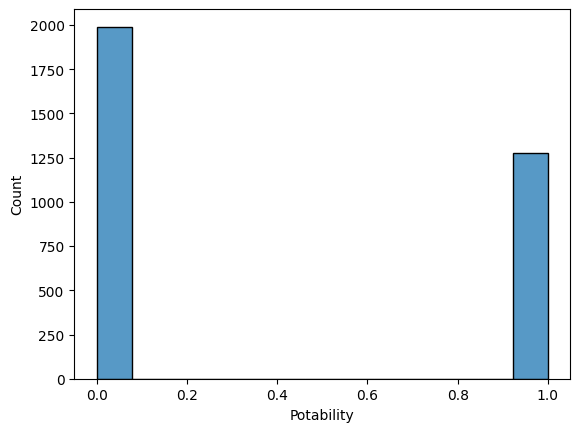

In [ ]:
from sklearn.preprocessing import LabelEncoder
from pandas import get_dummies

plt.figure()
sns.histplot(data=df, x="Potability")

In [ ]:
df = df_no_outliers  

In [ ]:
zero  = df[df['Potability']==0] 
one = df[df['Potability']==1] 
from sklearn.utils import resample
df_minority_upsampled = resample(zero, replace = True, n_samples = 1200) 

from sklearn.utils import shuffle
df = pd.concat([one, df_minority_upsampled])
df = shuffle(df)

## Balansiranje klasa (resampling)
Upsampling manjinske klase radi izbalansiranog dataseta.

<Axes: ylabel='count'>

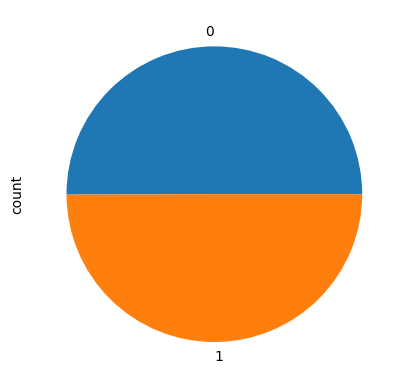

In [ ]:
df.Potability.value_counts().plot(kind ='pie')

In [ ]:
print('Counts of rows by class:')
print(df[target_column].value_counts())


Counts of rows by class:
Potability
0    1200
1    1198
Name: count, dtype: int64


In [ ]:
numerical_features = df.select_dtypes(include='number').columns.tolist()
print(f'There are {len(numerical_features)} numerical features:')
print(numerical_features, '\n')


There are 10 numerical features:
['pH', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'] 



In [ ]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
df[numerical_features].describe()

,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2398.000000,2398.000000,2398.000000,2398.000000,2398.000000,2398.000000,2398.000000,2398.000000,2398.000000,2398.000000
mean,7.053281,196.227236,21980.343131,7.159520,334.328898,424.734412,14.322537,66.469367,3.966102,0.499583
std,1.332106,32.747259,8356.918492,1.539101,34.852365,79.120147,3.309416,15.455019,0.778930,0.500104
min,2.803563,98.367915,728.750830,2.386653,225.516628,201.619737,4.371899,19.175175,1.641515,0.000000
25%,6.319667,176.662717,15737.037703,6.146947,317.831742,366.407590,12.091517,56.666459,3.442882,0.000000
50%,7.073783,197.076345,21178.827521,7.155344,333.756672,419.779044,14.310837,66.303555,3.959518,0.000000
75%,7.771865,218.150013,27365.106363,8.142210,351.134059,481.315865,16.579982,77.112538,4.501849,1.000000
max,11.496702,287.975540,48007.868134,11.753904,441.826777,657.570422,23.952450,113.048886,6.307678,1.000000


In [ ]:
df[numerical_features].describe()
minmax_df = df.copy()
minmax_scaler = MinMaxScaler(feature_range=(0,1))
minmax_df[numerical_features] = minmax_scaler.fit_transform(df[numerical_features])

df[numerical_features].describe()

,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2398.000000,2398.000000,2398.000000,2398.000000,2398.000000,2398.000000,2398.000000,2398.000000,2398.000000,2398.000000
mean,7.053281,196.227236,21980.343131,7.159520,334.328898,424.734412,14.322537,66.469367,3.966102,0.499583
std,1.332106,32.747259,8356.918492,1.539101,34.852365,79.120147,3.309416,15.455019,0.778930,0.500104
min,2.803563,98.367915,728.750830,2.386653,225.516628,201.619737,4.371899,19.175175,1.641515,0.000000
25%,6.319667,176.662717,15737.037703,6.146947,317.831742,366.407590,12.091517,56.666459,3.442882,0.000000
50%,7.073783,197.076345,21178.827521,7.155344,333.756672,419.779044,14.310837,66.303555,3.959518,0.000000
75%,7.771865,218.150013,27365.106363,8.142210,351.134059,481.315865,16.579982,77.112538,4.501849,1.000000
max,11.496702,287.975540,48007.868134,11.753904,441.826777,657.570422,23.952450,113.048886,6.307678,1.000000


In [ ]:
std_df = df.copy()
std_scaler = StandardScaler()
std_df[numerical_features] = std_scaler.fit_transform(df[numerical_features])
std_df[numerical_features].describe()

,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2.398000e+03,2.398000e+03,2.398000e+03,2.398000e+03,2.398000e+03,2.398000e+03,2.398000e+03,2.398000e+03,2.398000e+03,2.398000e+03
mean,-2.222298e-17,-6.978016e-16,3.555677e-16,6.459479e-16,6.170581e-16,-4.789052e-16,7.407660e-18,5.896497e-16,-6.548371e-16,-3.259370e-17
std,1.000209e+00,1.000209e+00,1.000209e+00,1.000209e+00,1.000209e+00,1.000209e+00,1.000209e+00,1.000209e+00,1.000209e+00,1.000209e+00
min,-3.190890e+00,-2.988944e+00,-2.543524e+00,-3.101721e+00,-3.122743e+00,-2.820536e+00,-3.007393e+00,-3.060757e+00,-2.984956e+00,-9.991663e-01
25%,-5.508318e-01,-5.975645e-01,-7.472381e-01,-6.580360e-01,-4.734427e-01,-7.373468e-01,-6.742838e-01,-6.344187e-01,-6.718571e-01,-9.991663e-01
50%,1.539420e-02,2.593457e-02,-9.593043e-02,-2.713911e-03,-1.642199e-02,-6.264398e-02,-3.536220e-03,-1.073092e-02,-8.455218e-03,-9.991663e-01
75%,5.395473e-01,6.695934e-01,6.444823e-01,6.386164e-01,4.822819e-01,7.152825e-01,6.822700e-01,6.887983e-01,6.879420e-01,1.000834e+00
max,3.336332e+00,2.802294e+00,3.115138e+00,2.985732e+00,3.085022e+00,2.943429e+00,2.910460e+00,3.014505e+00,3.006771e+00,1.000834e+00


In [ ]:
rbst_df = df.copy()
rbst_scaler = RobustScaler()
rbst_df[numerical_features] = rbst_scaler.fit_transform(df[numerical_features])
rbst_df[numerical_features].describe()

,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2398.000000,2.398000e+03,2.398000e+03,2398.000000,2398.000000,2398.000000,2398.000000,2398.000000,2398.000000,2398.000000
mean,-0.014118,-2.046672e-02,6.892938e-02,0.002093,0.017183,0.043125,0.002607,0.008110,0.006218,0.499583
std,0.917304,7.893322e-01,7.186850e-01,0.771378,1.046545,0.688550,0.737316,0.755892,0.735556,0.500104
min,-2.940522,-2.379245e+00,-1.758682e+00,-2.390006,-3.250226,-1.898552,-2.214329,-2.305008,-2.188927,0.000000
25%,-0.519293,-4.920453e-01,-4.679874e-01,-0.505395,-0.478193,-0.464470,-0.494450,-0.471342,-0.487868,0.000000
50%,0.000000,3.424995e-16,1.564504e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.480707,5.079547e-01,5.320126e-01,0.494605,0.521807,0.535530,0.505550,0.528658,0.512132,1.000000
max,3.045673,2.191013e+00,2.307265e+00,2.304739,3.245123,2.069402,2.148087,2.286274,2.217406,1.000000


In [ ]:
df.groupby('Potability').mean().T

Potability,0,1
pH,7.037775,7.068813
Hardness,196.581002,195.872880
Solids,21958.010724,22002.712820
Chloramines,7.180645,7.138360
Sulfate,334.956930,333.699818
Conductivity,424.502646,424.966565
Organic_carbon,14.426189,14.218712
Trihalomethanes,66.354378,66.584549
Turbidity,3.961594,3.970618


In [ ]:
X = df.drop(["Potability"],axis=1)
y = df["Potability"]

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.metrics import make_scorer
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_gamma_deviance
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import d2_absolute_error_score
from sklearn.metrics import d2_pinball_score
from sklearn.metrics import d2_tweedie_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
scoring_metrics = {
        'explained_variance': make_scorer(explained_variance_score),
        'max_error': make_scorer(max_error),
        'neg_mean_absolute_error': make_scorer(mean_absolute_error),
        'neg_mean_squared_error': make_scorer(mean_squared_error),
        'neg_root_mean_squared_error': make_scorer(mean_squared_error),
        'neg_mean_squared_log_error': make_scorer(mean_squared_log_error),
         'neg_median_absolute_error': make_scorer(median_absolute_error),
        'r2': make_scorer(r2_score),
         'neg_mean_poisson_deviance': make_scorer(mean_poisson_deviance),
         'neg_mean_gamma_deviance': make_scorer(mean_gamma_deviance),
         'neg_mean_absolute_percentage_error': make_scorer(mean_absolute_percentage_error),
         'd2_absolute_error_score': make_scorer(d2_absolute_error_score),
         'd2_pinball_score': make_scorer(d2_pinball_score),
         'd2_tweedie_score': make_scorer(d2_tweedie_score)
    }

# Priprema za treniranje modela

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize scalers
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

# Initialize models (bez NeuralNetwork)
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'SVM': svm.SVC(),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'NaiveBayes': GaussianNB()
}

# Initialize a dictionary to store results
results = {}

# Loop through each scaler and model, apply them, and evaluate performance
for scaler_name, scaler in scalers.items():
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        accuracy = accuracy_score(y_test, y_pred)
        results[(model_name, scaler_name)] = accuracy

# Add results for models without normalization
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    results[(model_name, 'NoScaler')] = accuracy

# Convert results to DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])
results_df.index = pd.MultiIndex.from_tuples(results_df.index, names=['Model', 'Scaler'])
results_df = results_df.unstack(level='Scaler')

c:\Users\anast\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Treniranje i evaluacija modela
Poredimo razlicite modele i skalere na obradjenim podacima.

In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])
results_df.index = pd.MultiIndex.from_tuples(results_df.index, names=['Model', 'Scaler'])
results_df = results_df.unstack(level='Scaler')

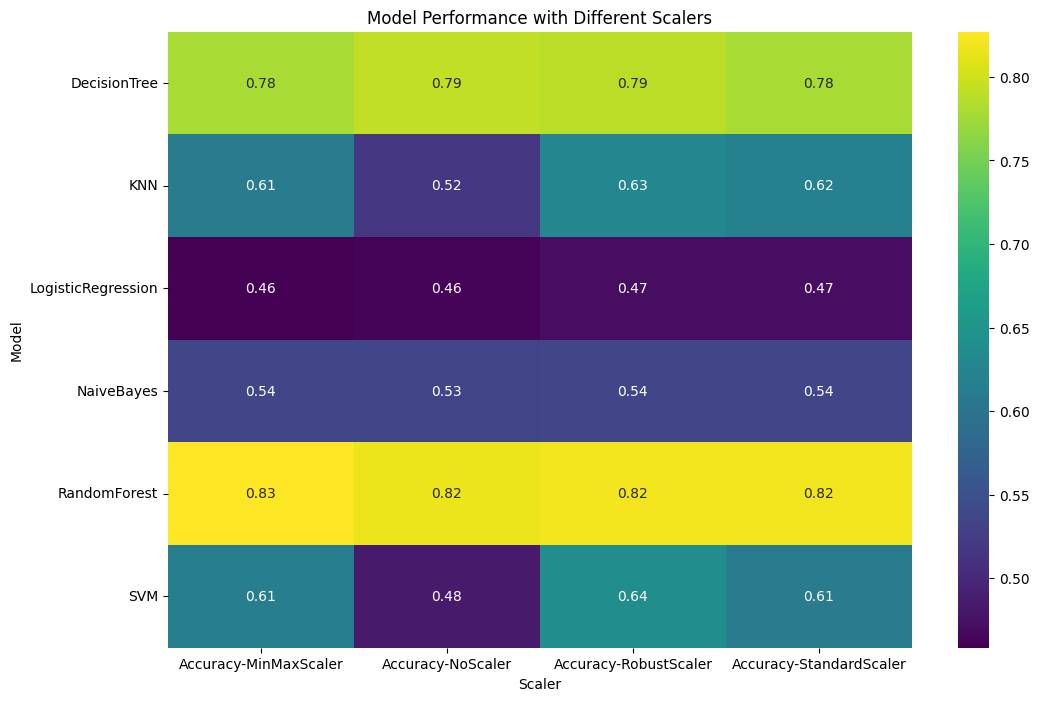

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(12, 8))

# Create a heatmap
sns.heatmap(results_df, annot=True, cmap='viridis', fmt=".2f")

# Add title and labels
plt.title('Model Performance with Different Scalers')
plt.xlabel('Scaler')
plt.ylabel('Model')

# Show the plot
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# Initialize scalers
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

# Initialize models (bez NeuralNetwork)
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'SVM': svm.SVC(),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'NaiveBayes': GaussianNB()
}

# Initialize a dictionary to store results
results = {}

# Define K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop through each scaler and model, apply them, and evaluate performance
for scaler_name, scaler in scalers.items():
    X_scaled = scaler.fit_transform(X)
    
    for model_name, model in models.items():
        scores = cross_val_score(model, X_scaled, y, cv=kf)
        results[(model_name, scaler_name)] = scores.mean()

# Add results for models without normalization
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=kf)
    results[(model_name, 'NoScaler')] = scores.mean()

# Convert results to DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])
results_df.index = pd.MultiIndex.from_tuples(results_df.index, names=['Model', 'Scaler'])
results_df = results_df.unstack(level='Scaler')

c:\Users\anast\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\anast\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])
results_df.index = pd.MultiIndex.from_tuples(results_df.index, names=['Model', 'Scaler'])
results_df = results_df.unstack(level='Scaler')

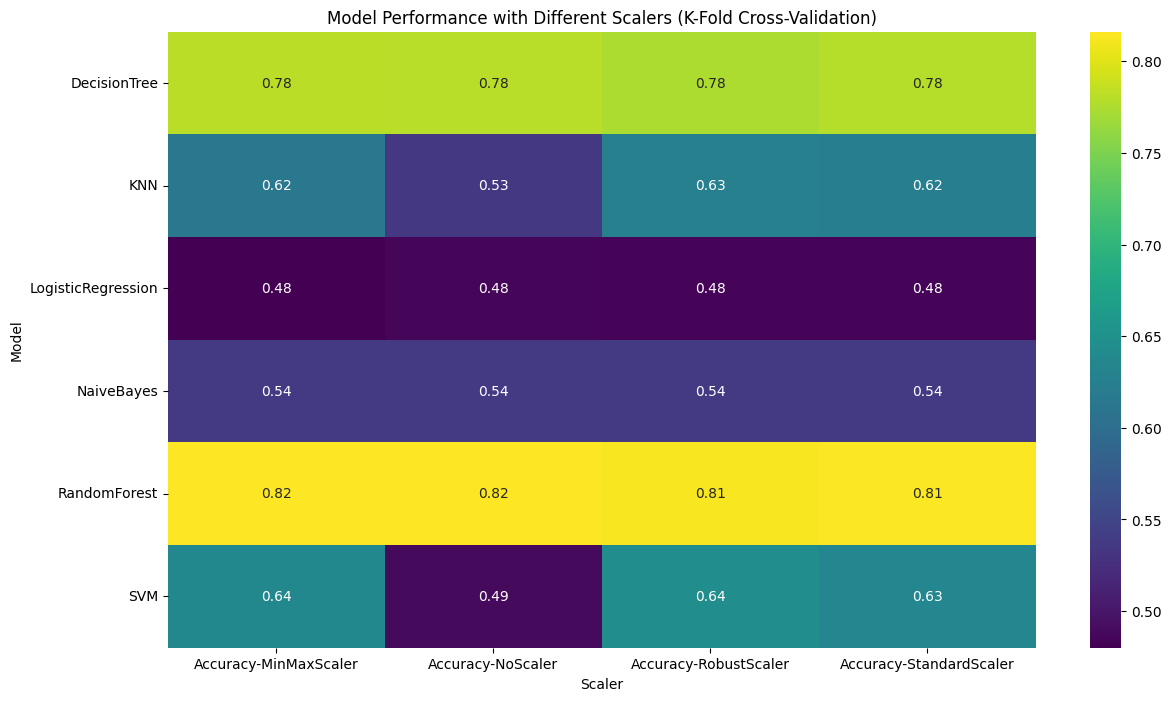

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(14, 8))

# Create a heatmap
sns.heatmap(results_df, annot=True, cmap='viridis', fmt=".2f")

# Add title and labels
plt.title('Model Performance with Different Scalers (K-Fold Cross-Validation)')
plt.xlabel('Scaler')
plt.ylabel('Model')

# Show the plot
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# Initialize scalers
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

# Initialize models
models = {
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(random_state=42),
    'ExtraTrees': ExtraTreesClassifier(random_state=42), 
    'AdaBoost': AdaBoostClassifier(random_state=42), 
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

# Initialize a dictionary to store results
results = {}

# Define K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop through each scaler and model, apply them, and evaluate performance
for scaler_name, scaler in scalers.items():
    X_scaled = scaler.fit_transform(X)
    
    for model_name, model in models.items():
        scores = cross_val_score(model, X_scaled, y, cv=kf)
        results[(model_name, scaler_name)] = scores.mean()

# Add results for models without normalization
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=kf)
    results[(model_name, 'NoScaler')] = scores.mean()

# Convert results to DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])
results_df.index = pd.MultiIndex.from_tuples(results_df.index, names=['Model', 'Scaler'])
results_df = results_df.unstack(level='Scaler')

c:\Users\anast\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\anast\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\anast\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\anast\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is 

## Ensemble modeli
Testiramo tree-based ensemble metode (RandomForest, ExtraTrees, AdaBoost, GradientBoosting).

In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])
results_df.index = pd.MultiIndex.from_tuples(results_df.index, names=['Model', 'Scaler'])
results_df = results_df.unstack(level='Scaler')

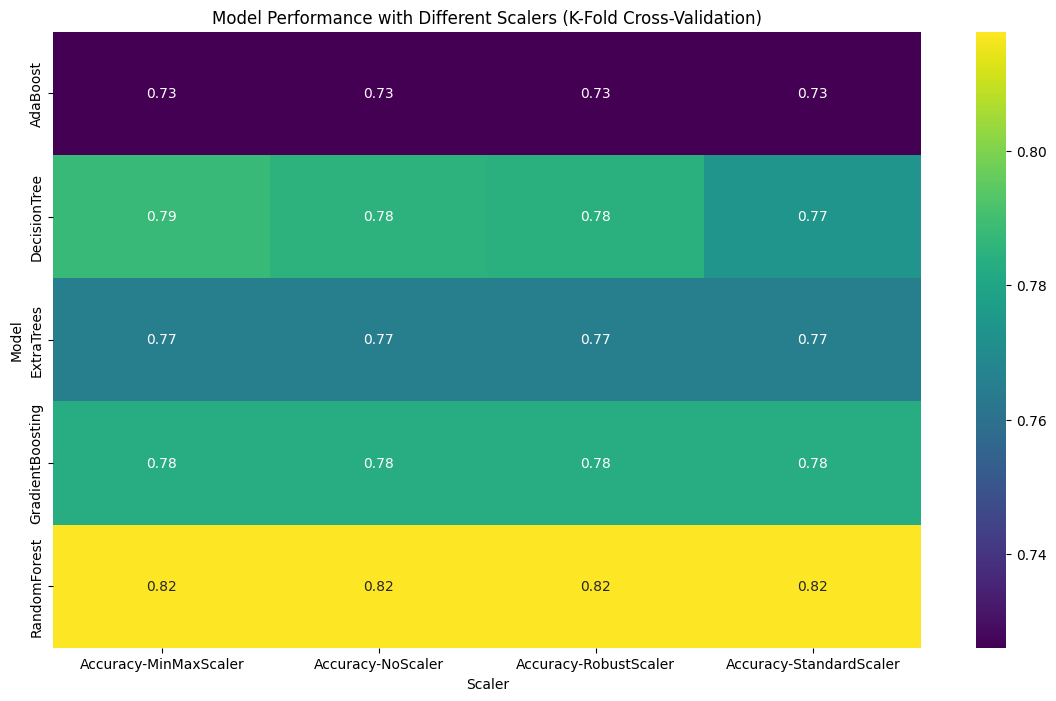

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(14, 8))

# Create a heatmap
sns.heatmap(results_df, annot=True, cmap='viridis', fmt=".2f")

# Add title and labels
plt.title('Model Performance with Different Scalers (K-Fold Cross-Validation)')
plt.xlabel('Scaler')
plt.ylabel('Model')

# Show the plot
plt.show()

In [ ]:
from scipy.stats import truncnorm, randint

from scipy import stats
#decTree_param_dist = {
#    'n_estimators': [50, 100, 200],
#    'max_depth': [None, 10, 20, 30],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4],
#    'bootstrap': [True, False]
#}

decTree_param_dist = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

## Optimizacija hiperparametara (GridSearch)
Pronalazenje optimalnih parametara za GradientBoostingClassifier.

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time

model = GradientBoostingClassifier(random_state=42)
cv = GridSearchCV(estimator=model, param_grid=decTree_param_dist, cv=5, n_jobs=-1, verbose=2)

#Prepare optimization
#randomCV = RandomizedSearchCV(model, scoring=scoring_metrics,
#                              param_distributions=decTree_param_dist, refit='neg_mean_absolute_error', 
#                              cv=cv, n_jobs=-1, n_iter=100)

grid_search = GridSearchCV(estimator=model, param_grid=decTree_param_dist, cv=5, n_jobs=-1, verbose=2)

In [ ]:
print(f"Optimizing hyperparameters with a randomized search...")
startTime = time.perf_counter()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
grid_search.fit(X_train_scaled, y_train)
endTime = time.perf_counter()
print(f"Parameters optimized in {endTime - startTime:0.4f} seconds.")

best_random_params = grid_search.best_params_

Optimizing hyperparameters with a randomized search...
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Parameters optimized in 305.0471 seconds.


In [ ]:
print(best_random_params)

{'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8}


In [ ]:
# Evaluate the best model on the test set
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy: ", accuracy)

Test set accuracy:  0.8041666666666667


In [ ]:
from scipy.stats import randint, uniform

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter distribution for Randomized Search
param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'subsample': uniform(0.8, 0.2)
}

# Initialize the GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42)

# Initialize Randomized Search with cross-validation
random_search = RandomizedSearchCV(estimator=gb, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)

print(f"Optimizing hyperparameters with a randomized search...")
startTime = time.perf_counter()

# Fit Randomized Search to the training data
random_search.fit(X_train_scaled, y_train)

endTime = time.perf_counter()
print(f"Parameters optimized in {endTime - startTime:0.4f} seconds.")

# Get the best parameters
best_random_params = random_search.best_params_
print("Best parameters found: ", best_random_params)

# Evaluate the best model on the test set
best_gb_random = random_search.best_estimator_
y_pred_random = best_gb_random.predict(X_test_scaled)

# Calculate accuracy
accuracy_random = accuracy_score(y_test, y_pred_random)
print("Test set accuracy: ", accuracy_random)

Optimizing hyperparameters with a randomized search...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Parameters optimized in 55.7771 seconds.
Best parameters found:  {'learning_rate': np.float64(0.09847044594622088), 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 138, 'subsample': np.float64(0.9320394753435464)}
Test set accuracy:  0.825


In [ ]:
def test_model(model, X: pd.DataFrame, Y: pd.DataFrame):
    #Prepare testing objects
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    #Training and testing
    cv_results = cross_validate(model, X, Y, scoring=scoring_metrics,
     cv=cv, n_jobs=-1)

    AccuScores = cv_results['test_accuracy']
    Prec0Scores = cv_results['test_precision_0']
    Prec1Scores = cv_results['test_precision_1']
    Rec0Scores = cv_results['test_recall_0']
    Rec1Scores = cv_results['test_recall_1']
    F10Scores = cv_results['test_f1_0']
    F11Scores = cv_results['test_f1_1']

    return { 
        'Accuracy': np.mean(AccuScores),
        'Precision 0': np.mean(Prec0Scores),
        'Precision 1': np.mean(Prec1Scores),
        'Recall 0': np.mean(Rec0Scores),
        'Recall 1': np.mean(Rec1Scores),
        'F1 0': np.mean(F10Scores),
        'F1 1': np.mean(F11Scores)
    }

## Evaluacija najboljeg modela
Confusion matrix, Feature Importance, ROC krivulja i AUC score.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# Treniranje najboljeg modela (GradientBoosting sa optimizovanim parametrima)
best_model = GradientBoostingClassifier(
    learning_rate=0.2,
    max_depth=5,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=200,
    subsample=0.8,
    random_state=42
)

# Skaliranje podataka
scaler_final = StandardScaler()
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_scaled_final = scaler_final.fit_transform(X_train_final)
X_test_scaled_final = scaler_final.transform(X_test_final)

# Treniranje
best_model.fit(X_train_scaled_final, y_train_final)
y_pred_final = best_model.predict(X_test_scaled_final)
y_pred_proba = best_model.predict_proba(X_test_scaled_final)[:, 1]

print("=== CLASSIFICATION REPORT ===")
print(classification_report(y_test_final, y_pred_final, target_names=['Nepitka (0)', 'Pitka (1)']))

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

 Nepitka (0)       0.76      0.84      0.80       222
   Pitka (1)       0.85      0.77      0.81       258

    accuracy                           0.80       480
   macro avg       0.81      0.81      0.80       480
weighted avg       0.81      0.80      0.80       480



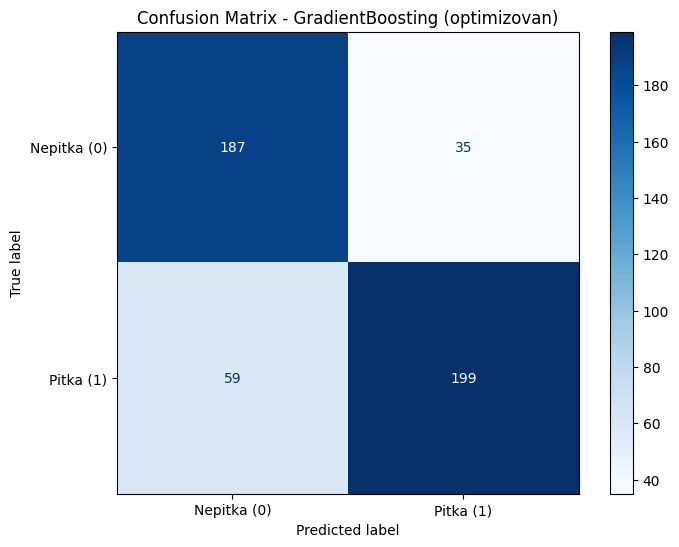


True Negatives (TN): 187
False Positives (FP): 35
False Negatives (FN): 59
True Positives (TP): 199

Accuracy: 0.8042
Precision (Pitka): 0.8504
Recall (Pitka): 0.7713


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test_final, y_pred_final)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Nepitka (0)', 'Pitka (1)'])
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix - GradientBoosting')
plt.show()

# Prikaz vrednosti
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")
print(f"\nAccuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}")
print(f"Precision (Pitka): {tp / (tp + fp):.4f}")
print(f"Recall (Pitka): {tp / (tp + fn):.4f}")

### Feature Importance

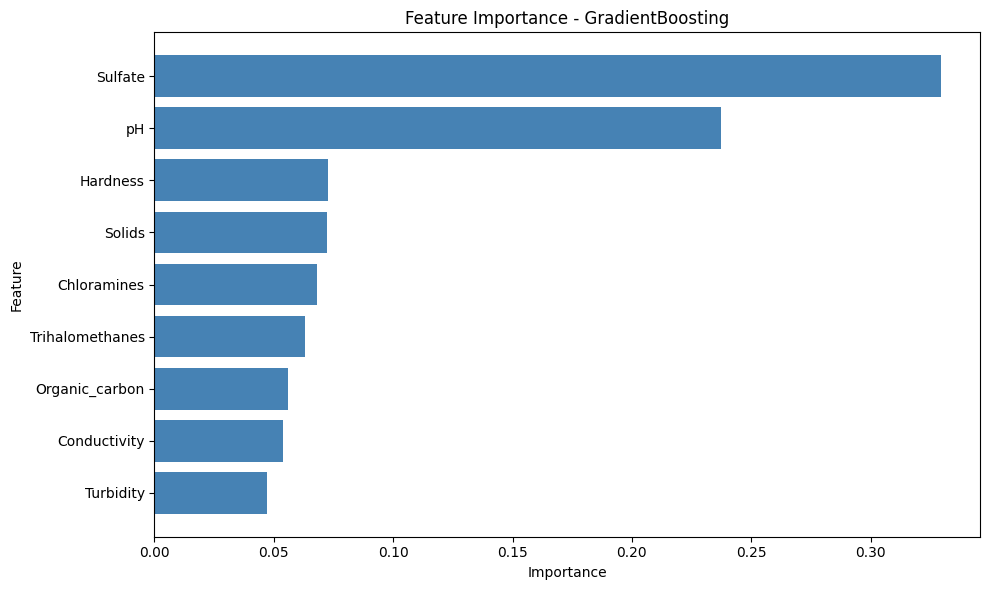


Feature Importance ranking:
  Sulfate: 0.3293
  pH: 0.2375
  Hardness: 0.0728
  Solids: 0.0722
  Chloramines: 0.0683
  Trihalomethanes: 0.0629
  Organic_carbon: 0.0559
  Conductivity: 0.0539
  Turbidity: 0.0470


In [ ]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - GradientBoosting')
plt.tight_layout()
plt.show()

print("\nFeature Importance ranking:")
for idx, row in feature_importance.sort_values('importance', ascending=False).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

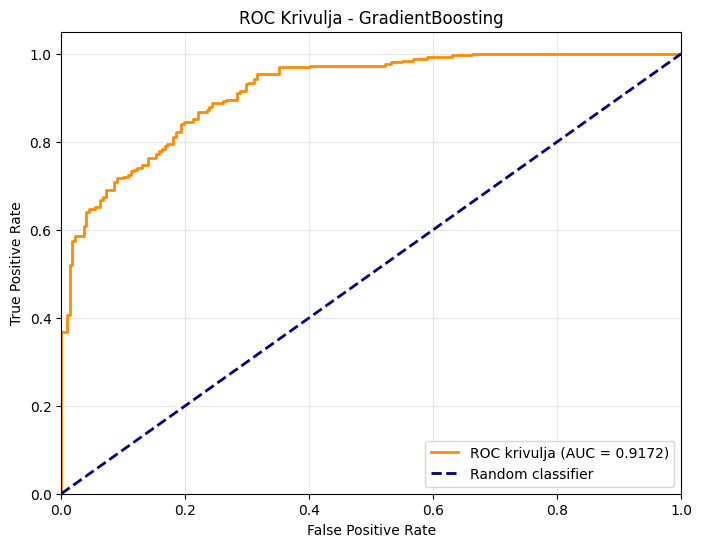

AUC Score: 0.9172


In [ ]:
# ROC krivulja i AUC
fpr, tpr, thresholds = roc_curve(y_test_final, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krivulja (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Krivulja - GradientBoosting')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"AUC Score: {roc_auc:.4f}")

### Sumarna tabela: Baseline vs Finalni model

SUMARNA TABELA: BASELINE vs FINALNI MODEL
                         Model  Accuracy (CV)      Std      Tip
GradientBoosting (optimizovan)       0.815684 0.018948  Finalni
                  RandomForest       0.669322 0.029727 Baseline
                    NaiveBayes       0.620586 0.024720 Baseline
                  DecisionTree       0.614116 0.029991 Baseline
            LogisticRegression       0.598720 0.028802 Baseline
                           KNN       0.545502 0.015691 Baseline


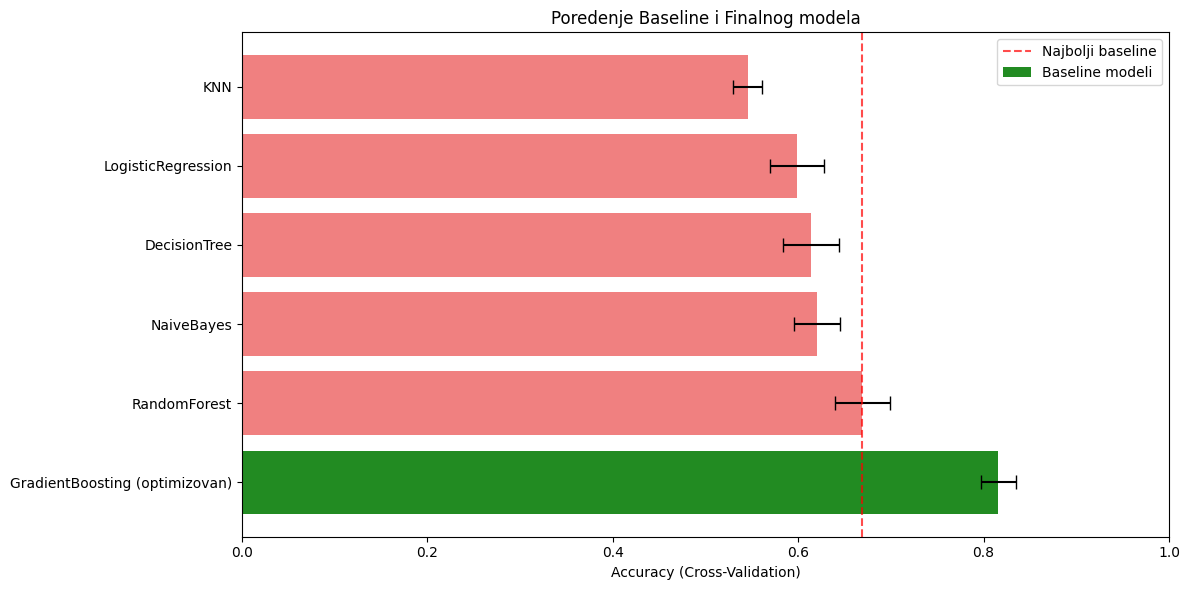


Poboljsanje u odnosu na najbolji baseline: 21.87%
Baseline (best): 0.6693 -> Finalni: 0.8157


In [ ]:
# Sumarna tabela: Baseline vs Finalni rezultati
from sklearn.metrics import precision_score, recall_score, f1_score

# Finalni model accuracy (sa CV)
kf_final = KFold(n_splits=5, shuffle=True, random_state=42)
final_model_for_cv = GradientBoostingClassifier(
    learning_rate=0.2, max_depth=5, min_samples_leaf=2,
    min_samples_split=2, n_estimators=200, subsample=0.8, random_state=42
)
X_scaled_all = scaler_final.fit_transform(X)
final_cv_scores = cross_val_score(final_model_for_cv, X_scaled_all, y, cv=kf_final)

# Kreiranje sumarne tabele
summary_data = {
    'Model': [],
    'Accuracy (CV)': [],
    'Std': [],
    'Tip': []
}

# Baseline rezultati
for name, result in baseline_results_cv.items():
    summary_data['Model'].append(name)
    summary_data['Accuracy (CV)'].append(result['mean'])
    summary_data['Std'].append(result['std'])
    summary_data['Tip'].append('Baseline')

# Finalni model
summary_data['Model'].append('GradientBoosting (optimizovan)')
summary_data['Accuracy (CV)'].append(final_cv_scores.mean())
summary_data['Std'].append(final_cv_scores.std())
summary_data['Tip'].append('Finalni')

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Accuracy (CV)', ascending=False)

print("=" * 70)
print("SUMARNA TABELA: BASELINE vs FINALNI MODEL")
print("=" * 70)
print(summary_df.to_string(index=False))
print("=" * 70)

# Vizualizacija
plt.figure(figsize=(12, 6))
colors = ['lightcoral' if t == 'Baseline' else 'forestgreen' for t in summary_df['Tip']]
bars = plt.barh(summary_df['Model'], summary_df['Accuracy (CV)'], color=colors, xerr=summary_df['Std'], capsize=5)
plt.xlabel('Accuracy (Cross-Validation)')
plt.title('Poredenje Baseline i Finalnog modela')
plt.xlim(0, 1)
plt.axvline(x=summary_df[summary_df['Tip']=='Baseline']['Accuracy (CV)'].max(), 
            color='red', linestyle='--', alpha=0.7, label='Najbolji baseline')
plt.legend(['Najbolji baseline', 'Baseline modeli', 'Finalni model'])
plt.tight_layout()
plt.show()

# Poboljsanje
baseline_best = summary_df[summary_df['Tip']=='Baseline']['Accuracy (CV)'].max()
final_acc = summary_df[summary_df['Tip']=='Finalni']['Accuracy (CV)'].values[0]
improvement = ((final_acc - baseline_best) / baseline_best) * 100
print(f"\nPoboljsanje u odnosu na najbolji baseline: {improvement:.2f}%")
print(f"Baseline (best): {baseline_best:.4f} -> Finalni: {final_acc:.4f}")